# 数据栅格化

In [15]:
from pathlib import Path

import pandas as pd
import numpy as np

from utils.data_io import *

import rasterio as rio

In [16]:
data_path = Path("processed_ATL03_20221230185202_01561807_006_02_gt3r_cut_denoise.csv")
data = get_csv(data_path)

print(data.columns)
print("\n-------------------------\n")
# 只选择需要的列
data = data[
    [
        "Time (sec)",
        "Delta Time (sec)",
        "Longitude (deg)",
        "UTM Easting (m)",
        "UTM Northing (m)",
        "Cross-Track (m)",
        "Along-Track (m)",
        "Height (m HAE)",
        "Height (m MSL)",
        "Solar Elevation (deg)",
        "point_type",
    ]
]

print(data.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Time (sec)', 'Delta Time (sec)',
       'Segment ID', 'GT Num', 'Beam Num', 'Beam Type', 'Latitude (deg)',
       'Longitude (deg)', 'UTM Easting (m)', 'UTM Northing (m)', 'UTM Zone',
       'UTM Hemisphere', 'Cross-Track (m)', 'Along-Track (m)',
       'Height (m HAE)', 'Height (m MSL)', 'Classification',
       'Signal Confidence', 'Solar Elevation (deg)', 'point_type'],
      dtype='object')

-------------------------

Index(['Time (sec)', 'Delta Time (sec)', 'Longitude (deg)', 'UTM Easting (m)',
       'UTM Northing (m)', 'Cross-Track (m)', 'Along-Track (m)',
       'Height (m HAE)', 'Height (m MSL)', 'Solar Elevation (deg)',
       'point_type'],
      dtype='object')


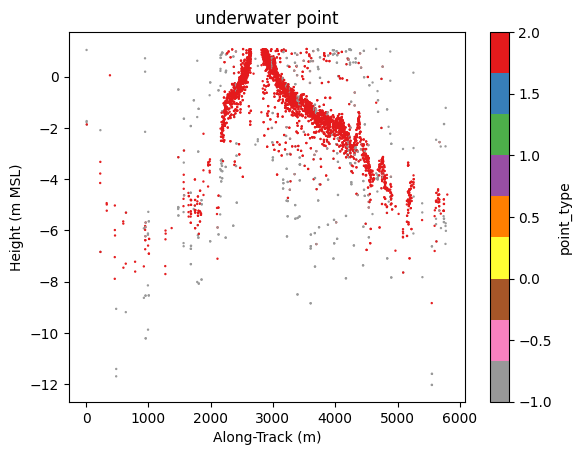

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'underwater point'}, xlabel='Along-Track (m)', ylabel='Height (m MSL)'>)

In [17]:
from utils.denoise import PointType, get_normal_distribution
from utils.plot import get_plt

under_water_point = data.loc[data["point_type"] == PointType.LandSurface.value]

block = {}

for index, point in under_water_point.iterrows():
    id = point["Along-Track (m)"] // 10
    id = int(id)
    if id not in block:
        block[id] = []
    block[id].append(point)

new_ds = []
available_keys = sorted(list(block.keys()))
for id in available_keys:
    ds = pd.DataFrame(block[id])
    if (id + 1) in available_keys:
        # 如果块是连续的则扩展窗口
        ds = pd.concat([ds, pd.DataFrame(block[id + 1])])

    ds["point_type"] = PointType.LandSurface.value
    heights = ds["Height (m MSL)"].values
    mu, sigma = get_normal_distribution(heights)
    if sigma > 1:
        ds.loc[
            (ds["Height (m MSL)"] < mu - 0.5 * sigma)
            | (ds["Height (m MSL)"] > mu + 0.5 * sigma),
            "point_type",
        ] = PointType.Noise.value
    new_ds.append(ds)

seafloor_point = pd.concat(new_ds)

get_plt(
    seafloor_point, x="Along-Track (m)", y="Height (m MSL)", title="underwater point"
)

In [18]:
blocks = []
block_num = set()

for id in block.keys():
    ds = pd.DataFrame(block[id])
    ds = ds.loc[ds["point_type"] == PointType.LandSurface.value]
    block_num.add(len(ds))

    # icesat-2的激光点间隔是0.7m
    # 每个block大小是5m
    # 如果block的点数小于一定值，说明这个block是无效的


    if len(ds) < 2:
        continue
    else:
        blocks.append(id)
    
print(f"有效的block数量: {len(blocks)}")
print(f"block内可能的数量: {block_num}")

bs = []
tmp = []
for id in blocks:
    if len(tmp) < 1:
        tmp.append(id)
        continue

    if id - tmp[-1] == 1:
        tmp.append(id)
    else:
        bs.append(tmp)
        tmp = []
        tmp.append(id)

select_ids = max(bs, key=len)
print(f"最大连续block的数量: {len(select_ids)}")
print(f"最大连续block: {select_ids}")

有效的block数量: 301
block内可能的数量: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}
最大连续block的数量: 67
最大连续block: [283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349]


In [ ]:
from utils.anti_rasterization import get_keypoint

# 复制data.columns
key_points = pd.DataFrame(columns=data.columns)
for id in select_ids:
    ds = pd.DataFrame(block[id])
    kp = get_keypoint(ds).to_frame().T
    key_points = pd.concat([key_points, kp], ignore_index=True)

print(
    "key_points Along-Track (m):\n"
    + key_points["Along-Track (m)"][:10].to_string(index=False)
)
print(f"key_points数量: {len(key_points)}")

save_csv(key_points, "keypoints", tag="centers")

key_points Along-Track (m):
2835.533537
2840.557493
2859.191400
2869.206269
2876.350104
2889.938914
2892.774983
2901.984021
2916.128407
2921.073234
2938.715572
2940.125873
2957.043213
2960.566825
2971.137224
2982.414670
2993.697261
3005.694051
3011.344099
3021.945152
3036.799079
3041.063283
3057.428893
3069.540777
3070.966721
3088.087724
3093.085042
3101.654179
3110.940773
3128.805275
3137.380465
3146.669451
3158.099690
3164.526639
3178.093139
3183.082564
3199.467741
3206.586119
3218.680483
3224.368510
3230.764936
3245.679917
3259.871337
3261.998927
3276.177327
3283.971597
3293.887509
3306.632225
3318.672149
3327.859204
3333.512877
3342.700673
3354.011733
3368.157881
3378.066414
3387.274233
3391.525167
3407.837333
3411.386809
3428.440454
3433.420032
3446.948223
3453.362772
3460.480936
3475.510147
3486.972108
3497.005736
key_points数量: 67
keypoints_centers.csv already exists, will be overwritten!


C:\Users\natsuu\AppData\Local\Temp\ipykernel_27092\583525468.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  key_points = pd.concat([key_points, kp], ignore_index=True)


False

len of key_points: 67


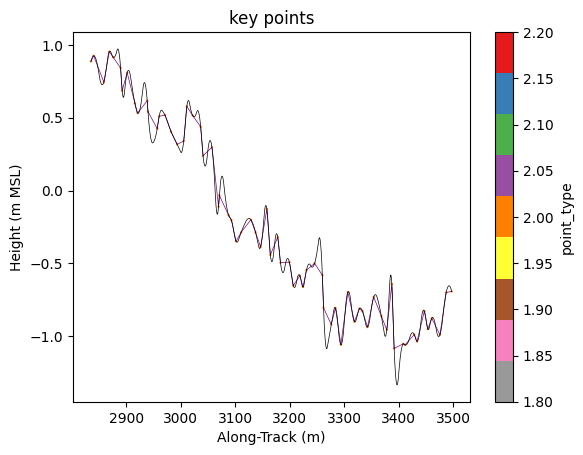

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'key points'}, xlabel='Along-Track (m)', ylabel='Height (m MSL)'>)

In [20]:
print(f"len of key_points: {len(key_points)}")
get_plt(
    key_points,
    x="Along-Track (m)",
    y="Height (m MSL)",
    title="key points",
    curve=True,
    straight=True,
    k=2,
    bc_type="not-a-knot",
    interpolations=10000,
)